In [170]:
import numpy as np
import psi4 
import ks_helper as ks

import matplotlib.pyplot as plt

from pkg_resources import parse_version
if parse_version(psi4.__version__) >= parse_version('1.3a1'):
    build_superfunctional = psi4.driver.dft.build_superfunctional
else:
    build_superfunctional = psi4.driver.dft_funcs.build_superfunctional

In [171]:
hydrogen = psi4.geometry("""
0 2

H

symmetry c1
""")

psi4.set_options({'DFT_SPHERICAL_POINTS': 50,
                  'DFT_RADIAL_POINTS':    75, 
                  'reference': 'uhf', 
                  'save_jk' : True})

In [173]:
h_energy, h_wfn = psi4.energy('HF/sto-3g',return_wfn=True)

Vpot = h_wfn.V_potential()

SystemError: <built-in method __init__ of PyCapsule object at 0x7fd294044630> returned NULL without setting an error

In [162]:
def one_electron_radial(matrices, Vpot):
    """
    For every matrix in matrices, computes the radial density using the incoming Vpot object.
    """
    
    results = [[] for x in matrices]
    Rlist = []
    
    points_func = Vpot.properties()[0]
    superfunc = Vpot.functional()

    xc_e = 0.0
    vv10_e = 0.0
    
    # First loop over the outer set of blocks
    for block in range(Vpot.nblocks()):
        
        # Obtain general grid information
        grid = Vpot.get_block(block)
        x = np.array(grid.x())
        y = np.array(grid.y())
        z = np.array(grid.z())
        npoints = z.shape[0]

        # Get radial information
        R = ((x ** 2) + (y ** 2) + (z ** 2)) ** 0.5
        Rlist.append(R)
        
        # Loop over and compute the density for each matrix
        for num, mat in enumerate(matrices):
            points_func.set_pointers(mat)
            points_func.compute_points(grid)
            results[num].append(np.array(points_func.point_values()["RHO_A"])[:npoints])
       
    # Stack R
    Rlist = np.hstack(Rlist)
    
    # Get the R unique and sort
    unique, uidx = np.unique(Rlist, return_index=True)
    Rlist = Rlist[uidx]
    
    # Numpy is magic, it would be worthwhile to consider excatly what this does
    results = [np.hstack(x)[uidx] for x in results]

    return (Rlist, results)

# Compute the radial densities
density_functional = build_superfunctional("SVWN", True)[0]
Vpot = psi4.core.VBase.build(h_wfn.basisset(), density_functional, "RV")
# build(arg0: psi4.core.BasisSet, arg1: psi4.core.SuperFunctional, arg2: str) → psi4.core.VBase¶
Vpot.initialize()

R, hartree = one_electron_radial([h_wfn.jk().J()[0]], Vpot)
R, kin_ext = one_electron_radial([h_wfn.H()],Vpot)
R, fock_a = one_electron_radial([h_wfn.Fa()],Vpot)
R, fock_b = one_electron_radial([h_wfn.Fb()],Vpot)

In [128]:
len(hartree)

1

In [129]:
exteral_potential=Vpot.compute_V
type(exteral_potential)

method

In [130]:
def plot_scatter_ratio(dictionary, bench, x_values):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    
    for k, v in dictionary.items():
        ax1.plot(x_values, v / bench, label=k)
        
    ax1.legend(loc='upper left')
    ax1.set_xlim(0, 7)
    ax1.set_xlabel('R')
    ax1.set_ylabel('rho(r) / rho(r)_bench')
    
    plt.plot([0, 7], [1.0, 1.0], 'k-')

/home/vh/anaconda3/envs/p4env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


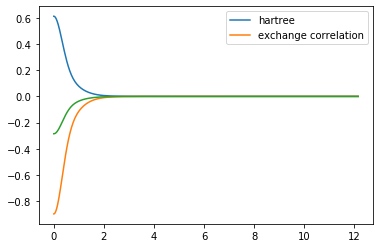

In [160]:
data_dict = {"SCF": data[0]}
plt.plot(R, hartree[0], label='hartree')
#plt.plot(R, kin_ext[0], label='kinetic+external')
#plt.plot(R, fock_a[0], label='focks')

equis = np.linspace(0,12,100)
ye = -1/equis
#
xc = (fock_a[0] + fock_b[0]) -(2 * hartree[0] + kin_ext[0] )

plt.plot(R, xc, label='exchange correlation')

plt.plot(R, hartree[0] + xc)

plt.legend()

In [138]:
fock_b[0] == fock_a[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [86]:
h_wfn.Da()

In [97]:
h_wfn.jk().J()[0]

In [147]:
dir(h_wfn.jk())

['C_add',
 'C_clear',
 'C_left_add',
 'C_right_add',
 'D',
 'J',
 'K',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'basisset',
 'build',
 'build_JK',
 'compute',
 'finalize',
 'initialize',
 'memory_estimate',
 'name',
 'print_header',
 'set_cutoff',
 'set_do_J',
 'set_do_K',
 'set_do_wK',
 'set_memory',
 'set_omega',
 'set_omp_nthread',
 'set_print',
 'wK']

In [145]:
h_wfn.H().shape

(1, 1)

In [142]:
dir(h_wfn.H())

['__array_interface__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'absmax',
 'accumulate_product',
 'add',
 'add_and_orthogonalize_row',
 'apply_denominator',
 'array_interface',
 'axpy',
 'back_transform',
 'chain_dot',
 'cholesky_factorize',
 'clone',
 'coldim',
 'cols',
 'copy',
 'copy_lower_to_upper',
 'copy_upper_to_lower',
 'diagonalize',
 'doublet',
 'from_array',
 'from_list',
 'from_serial',
 'gemm',
 'general_invert',
 'get',
 'get_block',
 'hermitivitize',
 'hermitize',
 'identity',
 'invert',
 'load',
 'load_mpqc',
 'name',
 'nirrep',
 'np',
 'np_read',
 'np_write',
 'nph',
 'partial_cholesky_factorize',
 'power',
 'print_atom_vector',
 '

In [ ]:
#Things that have the same structure as wfn.Da()

#wfn.Fa() full fock matrix
#wfn.H()  tiny h matrix -> kinetic + external potential